## Importing Packages

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

# To ignore warnings in the notebook
import warnings
warnings.filterwarnings("ignore")

## Importing Dataset

In [2]:
original = pd.read_csv('XWines_Full_100K_wines.csv')
data = original[['WineName', 'Type', 'Grapes', 'Harmonize', 'ABV', 'Body', 'Acidity', 'Country', 'Vintages', 'Website']]

## Data Cleaning

### Grapes

In [3]:
# creating a function to remove square brackets and quotation marks
# to be used on Grapes, Harmonize and Vintages
# inputs: data is the dataframe, column_names is the name of the column (string) or list
def clean_column(data, column_names):
    
    for column_name in column_names:

        if column_name in ['Grapes', 'Harmonize']:
            # extracting all words inside 
            data[column_name] = data[column_name].apply(lambda x: re.findall(r"'(.*?)'", x))

            # convert the list of words back to a string
            data[column_name] = data[column_name].apply(lambda x: ', '.join(x))
        
        else: 
            # removing the square brackets
            data[column_name] = data[column_name].apply(lambda x: str(x).strip('[]'))

    return data

In [4]:
original = clean_column(original, ['Grapes', 'Harmonize', 'Vintages'])
data = clean_column(data, ['Grapes', 'Harmonize', 'Vintages'])

In [5]:
# creating function to get the counts
# inputs: data is the dataframe, columns_name are the list of columns to get the counts

def get_counts(data, column_names):
    for column_name in column_names:
        data[column_name] = data[column_name].apply(lambda x: len(x.split(', ')))

    return data

In [6]:
df = get_counts(data, ['Grapes'])

In [7]:
unique_foods = df['Harmonize'].str.split(', ', expand=True).stack().value_counts()

unique_foods

Poultry                58315
Beef                   57774
Lamb                   38725
Game Meat              36436
Pork                   25406
                       ...  
Spiced Fruit Cake          1
Dried Fruits               1
Curry Chicken              1
Eggplant Parmigiana        1
Paella                     1
Name: count, Length: 66, dtype: int64

In [8]:
# re-classifying similar types of foods with the similar names into same categories
red_meat = ['Beef', 'Pork', 'Lamb', 'Veal', 'Meat', 'Ham', 'Red Meat']
white_meat = ['Chicken', 'Poultry', 'Duck', 'Cold Cuts']
cheese = ['Mild Cheese', 'Medium-cured Cheese', 'Cheese', 'Soft Cheese', 'Maturated Cheese', 'Hard Cheese', 'Goat Cheese', 'Blue Cheese']
seafood = ['Shellfish', 'Rich Fish', 'Lean Fish', 'Fish', 'Codfish', 'Seafood']
italian = ['Pasta', 'Risotto', 'Tagliatelle', 'Lasagna', 'Eggplant Parmigiana', 'Pizza']
dessert = ['Sweet Dessert', 'Fruit Dessert', 'Dessert', 'Citric Dessert', 'Cake', 'Soufflé', 'Chocolate', 'Spiced Fruit Cake']
vegetarian = ['Vegetarian', 'Mushrooms', 'Salad', 'Beans', 'Baked Potato', 'Chestnut']
snacks = ['Snack', 'French Fries', 'Fruit', 'Cookies']
others = ['Sushi', 'Sashimi', 'Yakissoba', 'Asian Food', 'Roast', 'Tomato Dishes', 'Cream', 'Curry Chicken', 'Barbeque', 'Light Stews', 'Paella', 'Grilled', 'Dried Fruits']
appetizer = ['Appetizer', 'Aperitif']

# checking if all other categories except Game Meat, Cured Meat and Spicy Food are classified
# total 67 (64 + 3)
# len(red_meat) + len(white_meat) + len(cheese) + len(seafood) + len(italian) + len(dessert) + len(vegetarian) + len(snacks) + len(others) + len(appetizer)

In [9]:
list_of_lists = [red_meat, white_meat, cheese, seafood, italian, dessert, vegetarian, snacks, others, appetizer]
names = ['Red Meat', 'White Meat', 'Cheese', 'Seafood', 'Italian', 'Dessert', 'Vegetarian', 'Snacks', 'Appetiser']

# define a function to re-assign the categories for each row
def reassign_categories(row):
    # splitting the food in the string and making it a list
    food_list = row.split(', ')

    # iterate through the list and re-assign the categories
    for i in range(len(food_list)):
        for lst, name in zip(list_of_lists, names):
            if food_list[i] in lst:
                food_list[i] = name

    # remove repeated food categories for each row
    new_row = list(set(food_list))

    # joining the list back into a string
    new_row = ', '.join(new_row)

    return new_row

# apply the function to each row of the DataFrame
df['Harmonize'] = df['Harmonize'].apply(reassign_categories)

In [10]:
# removing '-bodied' from body column
df['Body'] = df['Body'].str.replace('-bodied', '')

In [11]:
# saving the cleaned data
df.to_csv('wines_cleaned.csv')

In [12]:
# one-hot encoding the harmonise column
# Step 1: Create a list of all unique food types
food_types = df['Harmonize'].str.split(', ').explode().unique()
food_types = ['Harmonize_' + food_type for food_type in food_types]

# Step 2: Create a new DataFrame with a column for each unique food type
dummies = df['Harmonize'].str.get_dummies(', ').reindex(columns=food_types, fill_value=0)

# Step 3: Concatenate the original DataFrame with the new DataFrame
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Harmonize', 'Vintages', 'Website', 'WineName'], axis = 1)

In [13]:
# replace dessert/port to just dessert wine
df['Type'] = df['Type'].str.replace('Dessert/Port', 'Dessert')

In [14]:
# selecting only countries that appear more than 700 times
df = df[df['Country'].isin(['France', 'Italy', 'United States', 'Spain', 'Portugal', 'Germany', 'Australia', 'South Africa', 'Austria', 'Brazil', 'New Zealand', 'Canada', 'Switzerland'])]

In [15]:
# splitting the data into training and test
X = df.drop(columns = ['Type'])
y = df['Type']

# train_test_split on dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [16]:
# checking if there is imbalanced data
y.value_counts(normalize=True)

'''
There is imbalanced data so we should use ensemble techniques 
'''

'\nThere is imbalanced data so we should use ensemble techniques \n'

In [17]:
# function to get all categorical variables

def getCategorical(X_train, data):
    categorical_variables = []
    
    for column in X_train.columns:
        if data[column].dtype == "object":
            categorical_variables.append(column)

    return categorical_variables

In [18]:
# function to create a transformer to encode categorical variables

def transformer(categorical_variables):
    # One-hot encoding
    enc_rf = OneHotEncoder(sparse_output = False, handle_unknown = "ignore")

    transformer_rf = ColumnTransformer([
        ("categorical", enc_rf, categorical_variables)
    ], remainder="passthrough")

    return transformer_rf

In [19]:
# function to transform data

def transformData(X_train, X_test, transformer_rf):
    # when making predictions, there is no X_train and X_test
    # this condition is to handle that case
    if X_train is X_test:
        X_encoded = pd.DataFrame(transformer_rf.fit_transform(X_train), columns = transformer_rf.get_feature_names_out())
        
        return X_encoded

    else:  
        X_train_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_train), columns = transformer_rf.get_feature_names_out())
        X_test_encoded_rf = pd.DataFrame(transformer_rf.fit_transform(X_test), columns = transformer_rf.get_feature_names_out())
        
        return [X_train_encoded_rf, X_test_encoded_rf]

In [20]:
# function to rename the column to increase readability

def renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf):
    
    X_train_encoded_rf.columns = X_train_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)
    X_test_encoded_rf.columns = X_test_encoded_rf.columns.str.replace(re.compile(r'categorical__|remainder__'), '', regex = True)

    # used when making predictions
    if X_train_encoded_rf is X_test_encoded_rf:
        X_encoded = X_train_encoded_rf
        
        return X_encoded
    
    else:   
            return [X_train_encoded_rf, X_test_encoded_rf]


In [21]:
# function that combines all the above functions into a function called preprocess
def preprocess(X_train, X_test, data):
    
    # use the getCategorical function to get categorical variables in the dataset
    categorical_variables = getCategorical(X_train, data)
    
    # use tranformer function to create the transformer
    transformer_rf = transformer(categorical_variables)
    
    # use transformData function
    X_train_encoded_rf, X_test_encoded_rf = transformData(X_train, X_test, transformer_rf)

    # renaming the columns for readability
    X_train_encoded_rf, X_test_encoded_rf = renameCol(categorical_variables, X_train_encoded_rf, X_test_encoded_rf)

    return [X_train_encoded_rf, X_test_encoded_rf, transformer_rf]

### Random Forest Classifier

In [22]:
# unpacking values
X_train_encoded_rf, X_test_encoded_rf, transformer_rf = preprocess(X_train, X_test, df)

In [23]:
# class_weight = 'balanced' is used to give more weight to minority class
# the classes will be weighted inversely proportional to how frequently they appear in the data

rf = RandomForestClassifier(criterion = 'entropy', 
                            max_depth = 5, 
                            min_samples_leaf = 8, 
                            min_samples_split = 5, 
                            n_estimators = 100,
                            class_weight = 'balanced', 
                            random_state = 100)

rf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5, min_samples_leaf=8, min_samples_split=5,
                       random_state=100)

In [24]:
# creating a pipeline
pipeline_rf = Pipeline([("transformer", transformer_rf), ("random_forest", rf)])

In [25]:
# Helper function for cross validating
def show_cv_results(pipeline):
  scores = cross_validate(pipeline, X_train, y_train, cv = 10, return_train_score = True)
  print("Mean test score:", scores["test_score"].mean())
  display(pd.DataFrame(scores))

show_cv_results(pipeline_rf)

Mean test score: 0.6014786162636081


,fit_time,score_time,test_score,train_score
0,0.885043,0.031204,0.606926,0.609637
1,0.899927,0.031818,0.606360,0.603590
2,0.910923,0.031257,0.592226,0.591654
3,0.878668,0.030893,0.597173,0.593429
4,0.888521,0.030953,0.600226,0.603691
5,0.884591,0.031309,0.607860,0.612832
6,0.880491,0.030876,0.592169,0.595147
7,0.877441,0.031886,0.587079,0.595555
8,0.879041,0.030170,0.626661,0.626480
9,0.911048,0.030465,0.598106,0.594236


In [26]:
# helper function to calcualte AUC score for the model

def get_AUC (model, X, y):
    
    ###########
    # Calculate the AUC score.
    # Input: reg_model is the classifier, X is the X_test, Y is Y_test
    # Output: The AUC value.
    ###########

    # Make predictions on the test set
    y_pred = model.predict_proba(X)

    # Calculate the AUC score
    auc_score = roc_auc_score(y, y_pred, multi_class='ovr')
   
    return auc_score

In [27]:
# hyperparameters tuning
grid_rf = {
    'random_forest__n_estimators': [80, 100, 200, 300],
    'random_forest__max_depth': [5, 10, 15, 20],
    'random_forest__min_samples_split': [3, 5, 8, 10],
    'random_forest__min_samples_leaf': [2, 3, 5, 8]
}

rf_gs = GridSearchCV(estimator = pipeline_rf,
                      param_grid = grid_rf,
                      cv = 10,
                      n_jobs = -1,
                      return_train_score = True)

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['Body',
                                                                          'Acidity',
                                                                          'Country'])])),
                                       ('random_forest',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               max_depth=5,
                                                               min_samples_leaf=8,
                                                               min_samples_split=5,
                                                               random_state=100))]),
             n_jobs=-1,
             param_grid={'random_forest__max_depth': [5, 10, 15, 20],
                         'random_forest__min_samples_leaf': [2, 3, 5, 8],
                         'random_forest__min_samples_split': [3, 5, 8, 10],
                         'random_forest__n_estimators': [80, 100, 200, 300]},
             return_train_score=True)

In [28]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))


report_GridSearchCV_results(rf_gs)

Best combination of hyperparams:
 {'random_forest__max_depth': 15, 'random_forest__min_samples_leaf': 2, 'random_forest__min_samples_split': 3, 'random_forest__n_estimators': 200} 

Best mean_test_score score:
 0.7190434548053839 

Score by fold for best estimator:
 [0.7221201413427561, 0.7084098939929329, 0.7166077738515901, 0.71886925795053, 0.7189708792762228, 0.7271699180096126, 0.7195363302233532, 0.7189708792762228, 0.7199604184337008, 0.7198190556969183] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_random_forest__n_estimators,param_random_forest__max_depth,param_random_forest__min_samples_split,param_random_forest__min_samples_leaf
rank_test_score,,,,,
1,0.719043,200,15,3,2
2,0.718718,300,15,3,2
3,0.718605,80,15,3,2
4,0.718520,80,15,8,2
5,0.718436,100,15,8,2


### Fitting the best model

In [29]:
best_params = rf_gs.best_params_

clf = RandomForestClassifier(n_estimators = best_params['random_forest__n_estimators'],  
                             max_depth = best_params['random_forest__max_depth'],
                             min_samples_split = best_params['random_forest__min_samples_split'], 
                             min_samples_leaf = best_params['random_forest__min_samples_leaf'],
                             class_weight='balanced',
                             random_state = 100)

clf.fit(X_train_encoded_rf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200, random_state=100)

### Evaluating performance on test set

              precision    recall  f1-score   support

     Dessert       0.50      0.69      0.58       661
         Red       0.90      0.72      0.80      9625
        Rosé       0.23      0.66      0.34       737
   Sparkling       0.65      0.78      0.71      1417
       White       0.72      0.71      0.72      5247

    accuracy                           0.72     17687
   macro avg       0.60      0.71      0.63     17687
weighted avg       0.78      0.72      0.74     17687



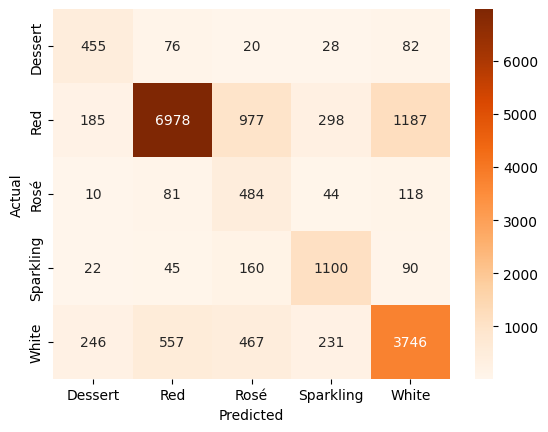

In [30]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

score_model(clf, X_test_encoded_rf, y_test)

In [31]:
# AUC scores
base_model = round(get_AUC(rf, X_test_encoded_rf, y_test), 2)
best_model = round(get_AUC(clf, X_test_encoded_rf, y_test), 2)

# increase in peformance
improvement = round((best_model - base_model)/base_model * 100, 2)

print(f'The AUC of the base model is: {base_model}')
print(f'The AUC of the best model is: {best_model}')
print(f'The improvement in performance is: {improvement}%')

The AUC of the base model is: 0.85
The AUC of the best model is: 0.91
The improvement in performance is: 7.06%


### Plotting feature importance

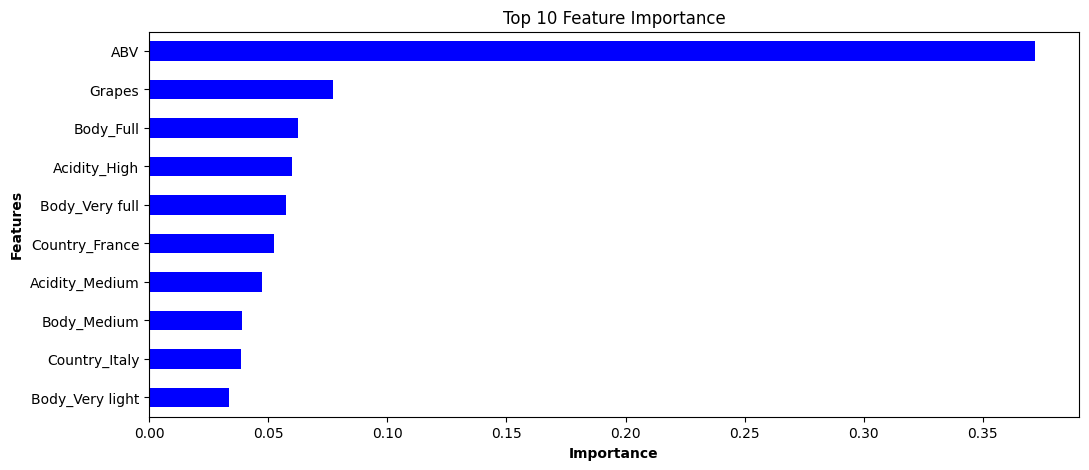

In [32]:
# helper function to get feature importance    
def plot_importance(model, X):

    importances = pd.Series(data=model.feature_importances_,
                            index= list(X.columns))
    
    importances_sorted = importances.sort_values()
    
    importances_sorted = importances_sorted[-10:]

    plt.figure(figsize = (12, 5))
    importances_sorted.plot(kind='barh', color='blue')
    plt.title('Top 10 Feature Importance')
    plt.xlabel("Importance", fontweight = 'bold')
    plt.ylabel("Features", fontweight = 'bold')
    plt.show()

plot_importance(rf_gs.best_estimator_.named_steps["random_forest"], X_train_encoded_rf)